# My submission to the ArangoDb Hackathon
## By Patrick Wendo

The dataset used in this notebook is available on Kaggle [here](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

In [1]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from arango import ArangoClient

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re

anime = pd.read_csv(
    "./datasets/myanimelist/anime.csv"
)

manga = pd.read_csv(
    "./datasets/myanimelist/manga.csv"
)

anime.info()
manga.head()


[19:46:06 +0300] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          24985 non-null  int64  
 1   title             24985 non-null  object 
 2   type              24927 non-null  object 
 3   score             16050 non-null  float64
 4   scored_by         24985 non-null  int64  
 5   status            24985 non-null  object 
 6   episodes          24438 non-null  float64
 7   start_date        24110 non-null  object 
 8   end_date          22215 non-null  object 
 9   source            21424 non-null  object 
 10  members           24985 non-null  int64  
 11  favorites         24985 non-null  int64  
 12  episode_duration  24387 non-null  object 
 13  total_duration    24162 non-null  object 
 14  rating            24405 non-null  object 
 15  sfw               24985 non-null  bool   
 16  approved          24985 non-null  bool  

,manga_id,title,type,score,scored_by,status,volumes,chapters,start_date,end_date,...,demographics,authors,serializations,synopsis,background,main_picture,url,title_english,title_japanese,title_synonyms
0,2,Berserk,manga,9.47,319696,currently_publishing,NaN,NaN,1989-08-25,NaN,...,['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...",['Young Animal'],"Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://cdn.myanimelist.net/images/manga/1/157...,https://myanimelist.net/manga/2/Berserk,Berserk,ベルセルク,['Berserk: The Prototype']
1,13,One Piece,manga,9.22,355375,currently_publishing,NaN,NaN,1997-07-22,NaN,...,['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...",['Shounen Jump (Weekly)'],"Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://cdn.myanimelist.net/images/manga/2/253...,https://myanimelist.net/manga/13/One_Piece,One Piece,ONE PIECE,[]
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,151433,finished,24.0,96.0,2004-01-19,2011-04-19,...,"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...",['Ultra Jump'],"In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://cdn.myanimelist.net/images/manga/3/179...,https://myanimelist.net/manga/1706/JoJo_no_Kim...,NaN,ジョジョの奇妙な冒険 Part7 STEEL BALL RUN,"[""JoJo's Bizarre Adventure Part 7: Steel Ball ..."
3,4632,Oyasumi Punpun,manga,9.02,168459,finished,13.0,147.0,2007-03-15,2013-11-02,...,['Seinen'],"[{'id': 2836, 'first_name': 'Inio', 'last_name...",['Big Comic Spirits'],Punpun Onodera is a normal 11-year-old boy liv...,Oyasumi Punpun was originally serialized in Yo...,https://cdn.myanimelist.net/images/manga/3/266...,https://myanimelist.net/manga/4632/Oyasumi_Punpun,Goodnight Punpun,おやすみプンプン,[]
4,25,Fullmetal Alchemist,manga,9.03,153151,finished,27.0,116.0,2001-07-12,2010-09-11,...,['Shounen'],"[{'id': 1874, 'first_name': 'Hiromu', 'last_na...",['Shounen Gangan'],Alchemists are knowledgeable and naturally tal...,Hagane no Renkinjutsushi won the 49th Shogakuk...,https://cdn.myanimelist.net/images/manga/3/243...,https://myanimelist.net/manga/25/Fullmetal_Alc...,Fullmetal Alchemist,鋼の錬金術師,"['Full Metal Alchemist', 'Hagane no Renkinjuts..."


### Data Exploration

- We have 2 datasets, anime and manga. 
- These are both relational datasets with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- The node label would be the name of the anime/manga. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly for columns like studios, themes, producers, licensors and demographics.

In [3]:
# Exploration of the anime dataset
pd.set_option("display.max.columns", None)
[anime.shape, manga.shape]

[(24985, 39), (64833, 30)]

- The anime dataset has about **24,985 rows with 39 columns**, while the manga dataset has **64,833 rows and 30 columns**

In [4]:
anime.head()

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,members,favorites,episode_duration,total_duration,rating,sfw,approved,created_at,updated_at,start_year,start_season,real_start_date,real_end_date,broadcast_day,broadcast_time,genres,themes,demographics,studios,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,3206028,219036,0 days 00:24:20,1 days 01:57:20,r,True,True,2008-08-21 03:35:22+00:00,2023-04-02 18:07:03+00:00,2009.0,spring,2009-04-05,2010-07-04,sunday,17:00:00,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],['Shounen'],['Bones'],"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148.0,2011-10-02,2014-09-24,manga,2688079,202109,0 days 00:23:37,2 days 10:15:16,pg_13,True,True,2011-07-27 08:41:39+00:00,2023-04-02 18:11:36+00:00,2011.0,fall,2011-10-02,2014-09-24,sunday,10:55:00,"['Action', 'Adventure', 'Fantasy']",[],['Shounen'],['Madhouse'],"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,2133927,55644,0 days 00:23:55,0 days 03:59:10,r,True,True,2018-10-14 18:13:45+00:00,2023-04-02 18:10:19+00:00,2019.0,spring,2019-04-29,2019-07-01,monday,00:10:00,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",['Shounen'],['Wit Studio'],"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24.0,2011-04-06,2011-09-14,visual_novel,2463954,184312,0 days 00:24:20,0 days 09:44:00,pg_13,True,True,2010-07-26 09:23:40+00:00,2023-04-02 18:08:42+00:00,2011.0,spring,2011-04-06,2011-09-14,wednesday,02:05:00,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",[],['White Fox'],"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1.0,2016-09-17,2016-09-17,manga,2218467,84124,0 days 02:10:03,0 days 02:10:03,pg_13,True,True,2014-12-15 08:00:46+00:00,2023-04-02 18:15:50+00:00,2016.0,summer,2016-09-17,2016-09-17,NaN,NaN,"['Award Winning', 'Drama']",['Romantic Subtext'],['Shounen'],['Kyoto Animation'],"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']


In [5]:
manga.head()

,manga_id,title,type,score,scored_by,status,volumes,chapters,start_date,end_date,members,favorites,sfw,approved,created_at_before,updated_at,real_start_date,real_end_date,genres,themes,demographics,authors,serializations,synopsis,background,main_picture,url,title_english,title_japanese,title_synonyms
0,2,Berserk,manga,9.47,319696,currently_publishing,NaN,NaN,1989-08-25,NaN,643969,119470,True,True,2007-07-17 20:14:45+00:00,2023-04-01 00:19:31+00:00,1989-08-25,NaN,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Gore', 'Military', 'Mythology', 'Psychologic...",['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...",['Young Animal'],"Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://cdn.myanimelist.net/images/manga/1/157...,https://myanimelist.net/manga/2/Berserk,Berserk,ベルセルク,['Berserk: The Prototype']
1,13,One Piece,manga,9.22,355375,currently_publishing,NaN,NaN,1997-07-22,NaN,579557,111462,True,True,2007-07-17 20:14:45+00:00,2023-06-24 12:39:48+00:00,1997-07-22,NaN,"['Action', 'Adventure', 'Fantasy']",[],['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...",['Shounen Jump (Weekly)'],"Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://cdn.myanimelist.net/images/manga/2/253...,https://myanimelist.net/manga/13/One_Piece,One Piece,ONE PIECE,[]
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,151433,finished,24.0,96.0,2004-01-19,2011-04-19,248511,41713,True,True,2007-10-07 08:14:20+00:00,2023-04-02 18:07:42+00:00,2004-01-19,2011-04-19,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Historical'],"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...",['Ultra Jump'],"In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://cdn.myanimelist.net/images/manga/3/179...,https://myanimelist.net/manga/1706/JoJo_no_Kim...,NaN,ジョジョの奇妙な冒険 Part7 STEEL BALL RUN,"[""JoJo's Bizarre Adventure Part 7: Steel Ball ..."
3,4632,Oyasumi Punpun,manga,9.02,168459,finished,13.0,147.0,2007-03-15,2013-11-02,413897,49361,True,True,2008-02-03 15:54:30+00:00,2023-04-02 18:09:11+00:00,2007-03-15,2013-11-02,"['Drama', 'Slice of Life']",['Psychological'],['Seinen'],"[{'id': 2836, 'first_name': 'Inio', 'last_name...",['Big Comic Spirits'],Punpun Onodera is a normal 11-year-old boy liv...,Oyasumi Punpun was originally serialized in Yo...,https://cdn.myanimelist.net/images/manga/3/266...,https://myanimelist.net/manga/4632/Oyasumi_Punpun,Goodnight Punpun,おやすみプンプン,[]
4,25,Fullmetal Alchemist,manga,9.03,153151,finished,27.0,116.0,2001-07-12,2010-09-11,284027,29634,True,True,2007-07-17 20:14:45+00:00,2023-05-27 17:21:27+00:00,2001-07-12,2010-09-11,"['Action', 'Adventure', 'Award Winning', 'Dram...",['Military'],['Shounen'],"[{'id': 1874, 'first_name': 'Hiromu', 'last_na...",['Shounen Gangan'],Alchemists are knowledgeable and naturally tal...,Hagane no Renkinjutsushi won the 49th Shogakuk...,https://cdn.myanimelist.net/images/manga/3/243...,https://myanimelist.net/manga/25/Fullmetal_Alc...,Fullmetal Alchemist,鋼の錬金術師,"['Full Metal Alchemist', 'Hagane no Renkinjuts..."


##### Data Fix #1
- Fix string that look like lists, `"[list, item]" -> ["list", "item"]`. This will allow us to use the #explode() function later when creating data in NetworkX

In [6]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]
manga_columns_to_fix = ["genres", "themes", "demographics", "authors"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def rewrite_manga(col):
    manga[col] = manga[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

for col in manga_columns_to_fix:
    rewrite_manga(col)

In [7]:
def update_anime_id(anime_df):
    anime_df["anime_id"] = anime_df["anime_id"].astype(str).apply(lambda x: f"a_{x}")
    return anime_df  # Ensure the function returns the updated DataFrame



anime = update_anime_id(anime)
anime.head(1)

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,members,favorites,episode_duration,total_duration,rating,sfw,approved,created_at,updated_at,start_year,start_season,real_start_date,real_end_date,broadcast_day,broadcast_time,genres,themes,demographics,studios,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,a_5114,Fullmetal Alchemist: Brotherhood,tv,9.1,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,3206028,219036,0 days 00:24:20,1 days 01:57:20,r,True,True,2008-08-21 03:35:22+00:00,2023-04-02 18:07:03+00:00,2009.0,spring,2009-04-05,2010-07-04,sunday,17:00:00,"[Action, Adventure, Drama, Fantasy]",[Military],[Shounen],[Bones],"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...


In [8]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

genre_explode = anime.explode('genres')
genre_grouped_data = genre_explode.groupby("genres")
anime_genres = genre_grouped_data.groups.keys()
print("Genres: ", list(set(list(genre_grouped_data.groups.keys()))))

theme_explode = anime.explode('themes')
theme_grouped_data = theme_explode.groupby("themes")
anime_themes = theme_grouped_data.groups.keys()
print("Themes: ", list(set(list(theme_grouped_data.groups.keys()))))

demographics_explode = anime.explode('demographics')
demographic_grouped_data = demographics_explode.groupby("demographics")
anime_demographics = demographic_grouped_data.groups.keys()
print("Demographics: ", list(set(list(demographic_grouped_data.groups.keys()))))

studios_explode = anime.explode('studios')
studio_grouped_data = studios_explode.groupby("studios")
anime_studios = studio_grouped_data.groups.keys()
print("Studios: ", list(set(list(studio_grouped_data.groups.keys()))))

Genres:  ['Gourmet', 'Mystery', 'Slice of Life', 'Sci-Fi', 'Erotica', 'Romance', 'Boys Love', 'Hentai', 'Girls Love', 'Ecchi', 'Suspense', 'Action', 'Adventure', 'Comedy', 'Sports', 'Fantasy', 'Award Winning', 'Supernatural', 'Horror', 'Drama', 'Avant Garde']
Themes:  ['Parody', 'Harem', 'Pets', 'Time Travel', 'Romantic Subtext', 'Mahou Shoujo', 'Combat Sports', 'Crossdressing', 'Military', 'Otaku Culture', 'Gore', 'Survival', 'High Stakes Game', 'Mythology', 'Space', 'Idols (Female)', 'Racing', 'Visual Arts', 'CGDCT', 'Isekai', 'Martial Arts', 'Super Power', 'Educational', 'Magical Sex Shift', 'Childcare', 'Reincarnation', 'Team Sports', 'Gag Humor', 'Iyashikei', 'Strategy Game', 'Delinquents', 'Historical', 'Idols (Male)', 'School', 'Music', 'Psychological', 'Video Game', 'Adult Cast', 'Samurai', 'Vampire', 'Medical', 'Performing Arts', 'Reverse Harem', 'Showbiz', 'Anthropomorphic', 'Detective', 'Mecha', 'Organized Crime', 'Love Polygon', 'Workplace']
Demographics:  ['Shounen', 'Kids

##### Authors column in Manga.
- The author field in Manga datasets should be extracted into it's own dataset. Each author will be a node on it's own. They may be shared across datasets. The node label will be the id with attributes being first name, last name and role. 

In [9]:
manga_authors = manga["authors"]
manga_authors.explode().head()[0]

0    {'id': 1868, 'first_name': 'Kentarou', 'last_n...
0    {'id': 49592, 'first_name': '', 'last_name': '...
Name: authors, dtype: object

##### Creating new DataFrames for NetworkX compatibility

- The node data needs to be in a form like 
```
    {
        node: <node-name>,
        attribute_1: <attribute_1>,
        attribute_2: <attribute_2>,
        attribute_3: <attribute_3>,

    }
```

- Further, we need to define edge data. This would be an edge list of the form:
```
    {
        source: <source>,
        target: <target>,
        attribute_1: <attribute_1>,
        attribute_2: <attribute_2>,
        attribute_3: <attribute_3>,
    }
```

In [10]:
# Building dataframe for "genres", "themes", "demographics", "studios" to be used in building nodes. 

demographics_df = pd.DataFrame(anime_demographics, columns=['demographics']).reset_index()
current_idx = len(demographics_df)

genres_df = pd.DataFrame(anime_genres, columns=['genres']).reset_index(drop=True)
themes_df = pd.DataFrame(anime_themes, columns=["themes"]).reset_index()
studios_df = pd.DataFrame(anime_studios, columns=['studios']).reset_index()
# genres_df

list_of_dfs = [demographics_df, genres_df, themes_df, studios_df]

def update_indices(list_dfs):
    current_idx = 0
    for i in range(len(list_dfs)):  
        list_dfs[i] = list_dfs[i].reset_index(drop=True) 
        list_dfs[i]['index'] = range(current_idx, current_idx + len(list_dfs[i])) 
        list_dfs[i].index = range(current_idx, current_idx + len(list_dfs[i]))
        current_idx += len(list_dfs[i])

    return list_dfs  # Optional: return updated list


[demographics_df_idx, genres_df_idx, themes_df_idx, studios_df_idx] = update_indices(list_of_dfs)

##### Making the dataframe that can be loaded into networkX

The dataframes `demographics_df_idx, genres_df_idx, themes_df_idx, studios_df_idx` all have unique indices. These will be used in defining an edge list for the anime dataset. For now we work on creating the node list for the anime. 



In [11]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms" 
}

(node_attributes.values())
attributed_anime = anime[anime.columns.intersection(list(node_attributes.values()))]


In [12]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field):
    exploded_df = dataframe1.explode(merge_field)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field, right_on=merge_field)
    edge_list_df = edge_list_df[['anime_id', 'index']]
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_df_idx, "demographics")
genres_edge_list = build_edge_list(anime, genres_df_idx, "genres")
themes_edge_list = build_edge_list(anime, themes_df_idx, "themes")
studios_edge_list = build_edge_list(anime, studios_df_idx, "studios")


#### NetworkX

- Playing around with NetworkX

In [13]:

# Adding nodes for "genres", "themes", "demographics", "studios"
G = nx.Graph()

demographic_attributes = demographics_df_idx.set_index('index').to_dict(orient='index')
genres_attributes = genres_df_idx.set_index('index').to_dict(orient='index')
themes_attributes = themes_df_idx.set_index('index').to_dict(orient='index')
studios_attributes = studios_df_idx.set_index('index').to_dict(orient='index')
G.add_nodes_from(demographic_attributes.items())
G.add_nodes_from(genres_attributes.items())
G.add_nodes_from(themes_attributes.items())
G.add_nodes_from(studios_attributes.items())
G.add_nodes_from(attributed_anime.set_index('anime_id').to_dict(orient='index').items())
theme_edges = list(themes_edge_list.itertuples(index=False, name=None))
genres_edges = list(genres_edge_list.itertuples(index=False, name=None))
demographics_edges = list(demographics_edge_list.itertuples(index=False, name=None))
studios_edges = list(studios_edge_list.itertuples(index=False, name=None))
G.add_edges_from(theme_edges)
G.add_edges_from(genres_edges)
G.add_edges_from(demographics_edges)
G.add_edges_from(studios_edges)
G.size()
# print(studios_attributes.items())


83360

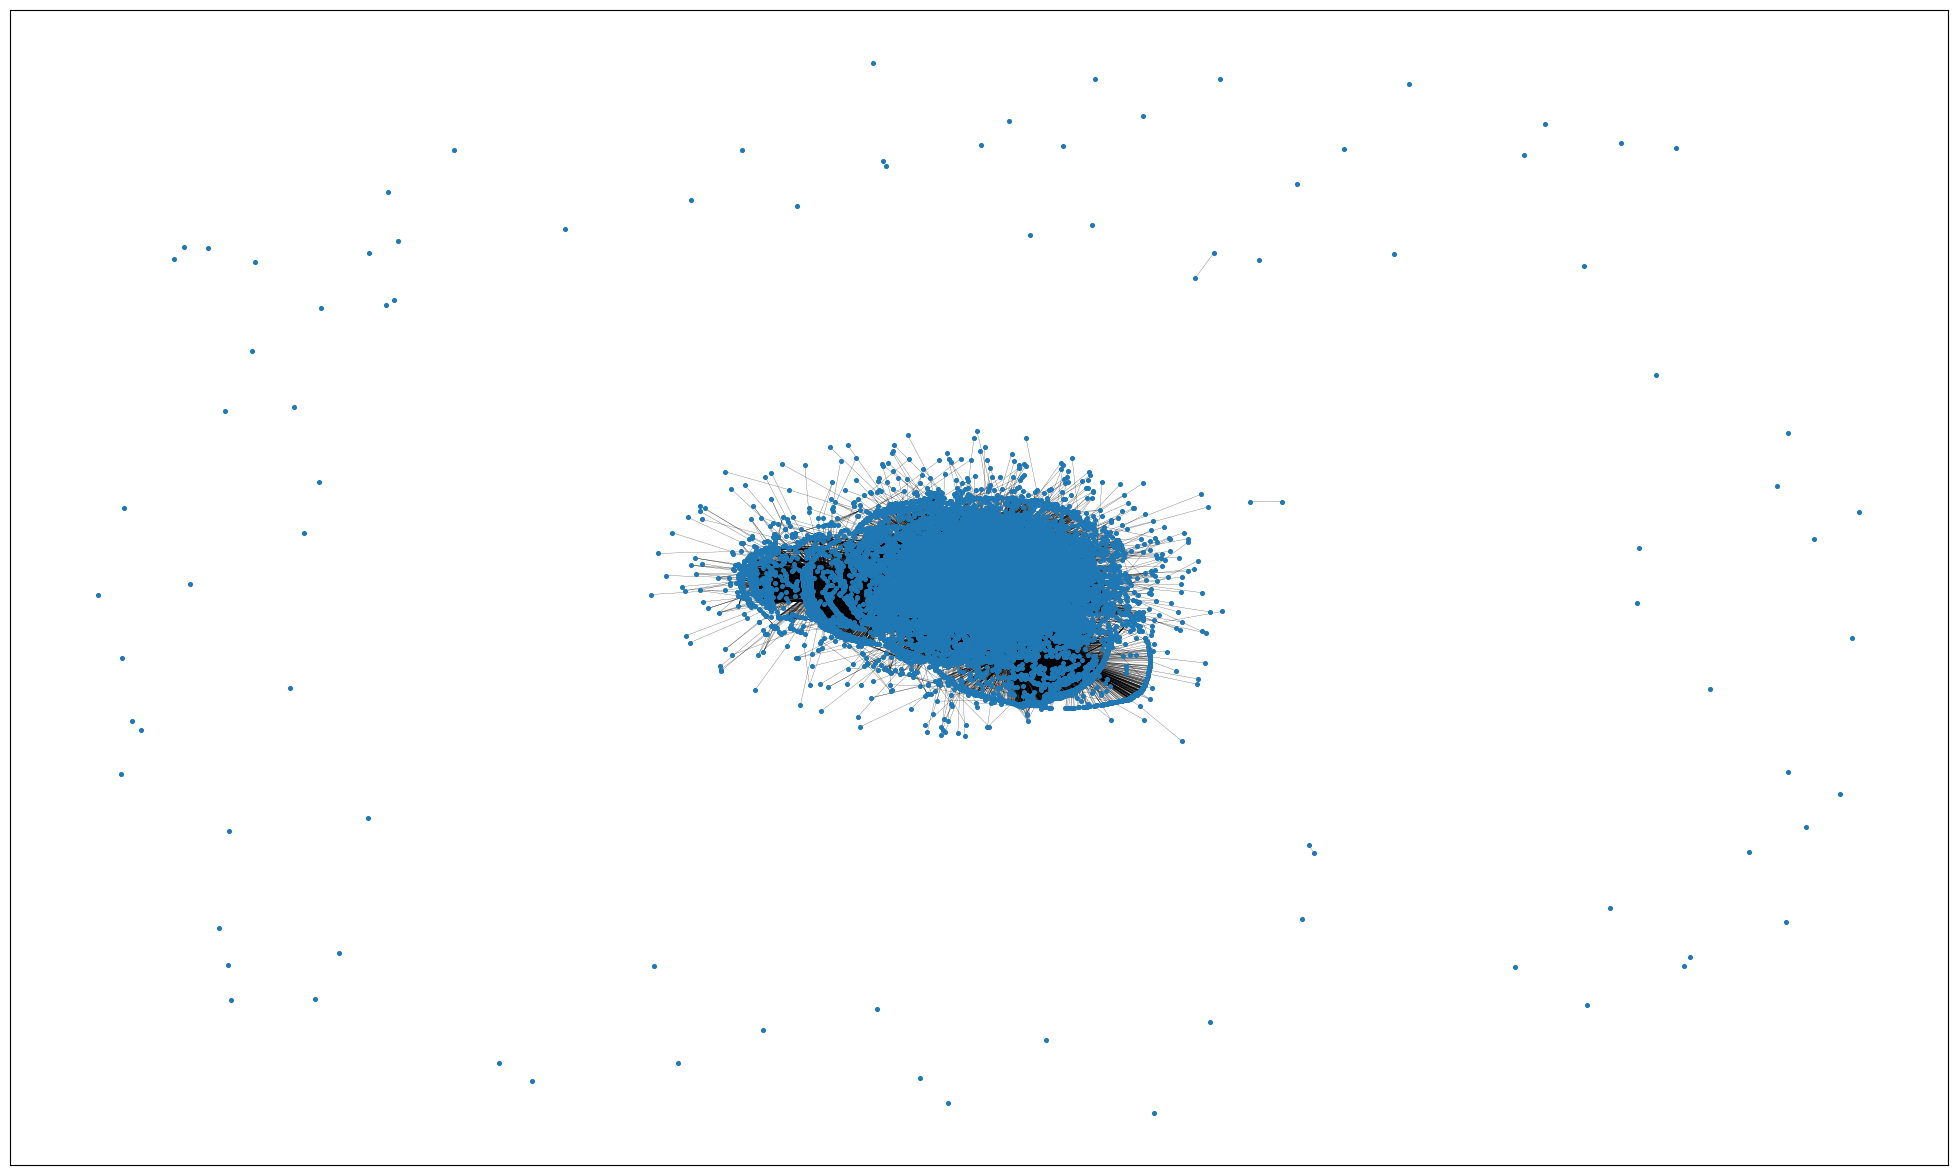

In [ ]:
plot_options = {"node_size": 7, "with_labels": False, "width": 0.05}
pos = nx.spring_layout(G, iterations=15, seed=1719)
fig, ax = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
nx.draw(G)